### Toolbox for Model/Feature Interpretation
---

Some thoughts:
* Use shap to study behaviors
* Generate trend with WOE or simple lin reg
* Match whether they measure up
* If not, is there a reason for it?
    * Lime?
    * Look at local data points
    * Interaction effects?
    
We can use numbers to indicate the depth needed to drill in:
* 0: makes sense. No effort needed.
* 1: mostly makes sense. Some special behavior
* 2: isn't clear. Need to go deep.

Couple ways to analyze each:
* shap interactive plots
* woe based on the provided bins
* my transaction visualizer
* ice plots
* lime and other local explanation methods, AIX or Interpret

In [1]:
import sys, os
sys.path.insert(1, '../..')
import pandas as pd
import numpy as np
import pickle as pkl
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
import rdsutils.plot as rdsplot
import shap, math
from tqdm import tqdm


# feature preprocessing, if needed
from train import preprocess

plt.style.use('seaborn')

%load_ext autoreload
%autoreload 2

In [2]:
modeling_df = pd.read_feather("../../artifacts/modeling_df_final_with_oof_preds_replication.feather")
modeling_df = preprocess(modeling_df)
modeling_df.shape

(1086183, 48)

<AxesSubplot:>

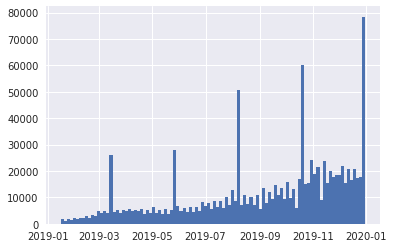

In [3]:
modeling_df.sample_date.hist(bins=100)

In [4]:
# get scores
model = pkl.load(open('../../models/customer_risk_target_no_giact_time_since_last_link.pkl', 'rb'))

In [56]:
modeling_df.columns

Index(['business_account_number', 'borrower_id', 'sample_date', 'target',
       'transaction_code', 'first_deposit_amount', 'vantage_score', 'bcc7120',
       'email_risk_score', 'fraud_score_2', 'name_email_correlation',
       'transaction_as_pct_of_balance', 'mean_account_balance_30d',
       'giact_time_since_last_link', 'phone_risk_score',
       'name_address_correlation', 'all8220', 'lag_acc_open_first_transaction',
       'dollar_val_dd', 'all7120', 'sum_deposits_10d', 'nr_past_transactions',
       'total_tradelines_open', 'education_loan_amount', 'address_risk_score',
       'iqt9415', 'max_withdrawals_30d', 'iln5520', 'max_deposits_30d',
       'pct_returned_deposits', 'giact_nr_decline', 'nr_direct_deposits',
       'time_since_last_transaction', 'bal_ratio', 'name_phone_correlation',
       'giact_nr_other', 'dollar_val_returns', 'nr_trans_ratio', 'iqt9413',
       'dollar_val_returns_3d', 'nr_returns_30d', 'credit_card_loan_amount',
       'fraud_score_1', 'age_money_acc

#### SHAP
---

#### Overview

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.


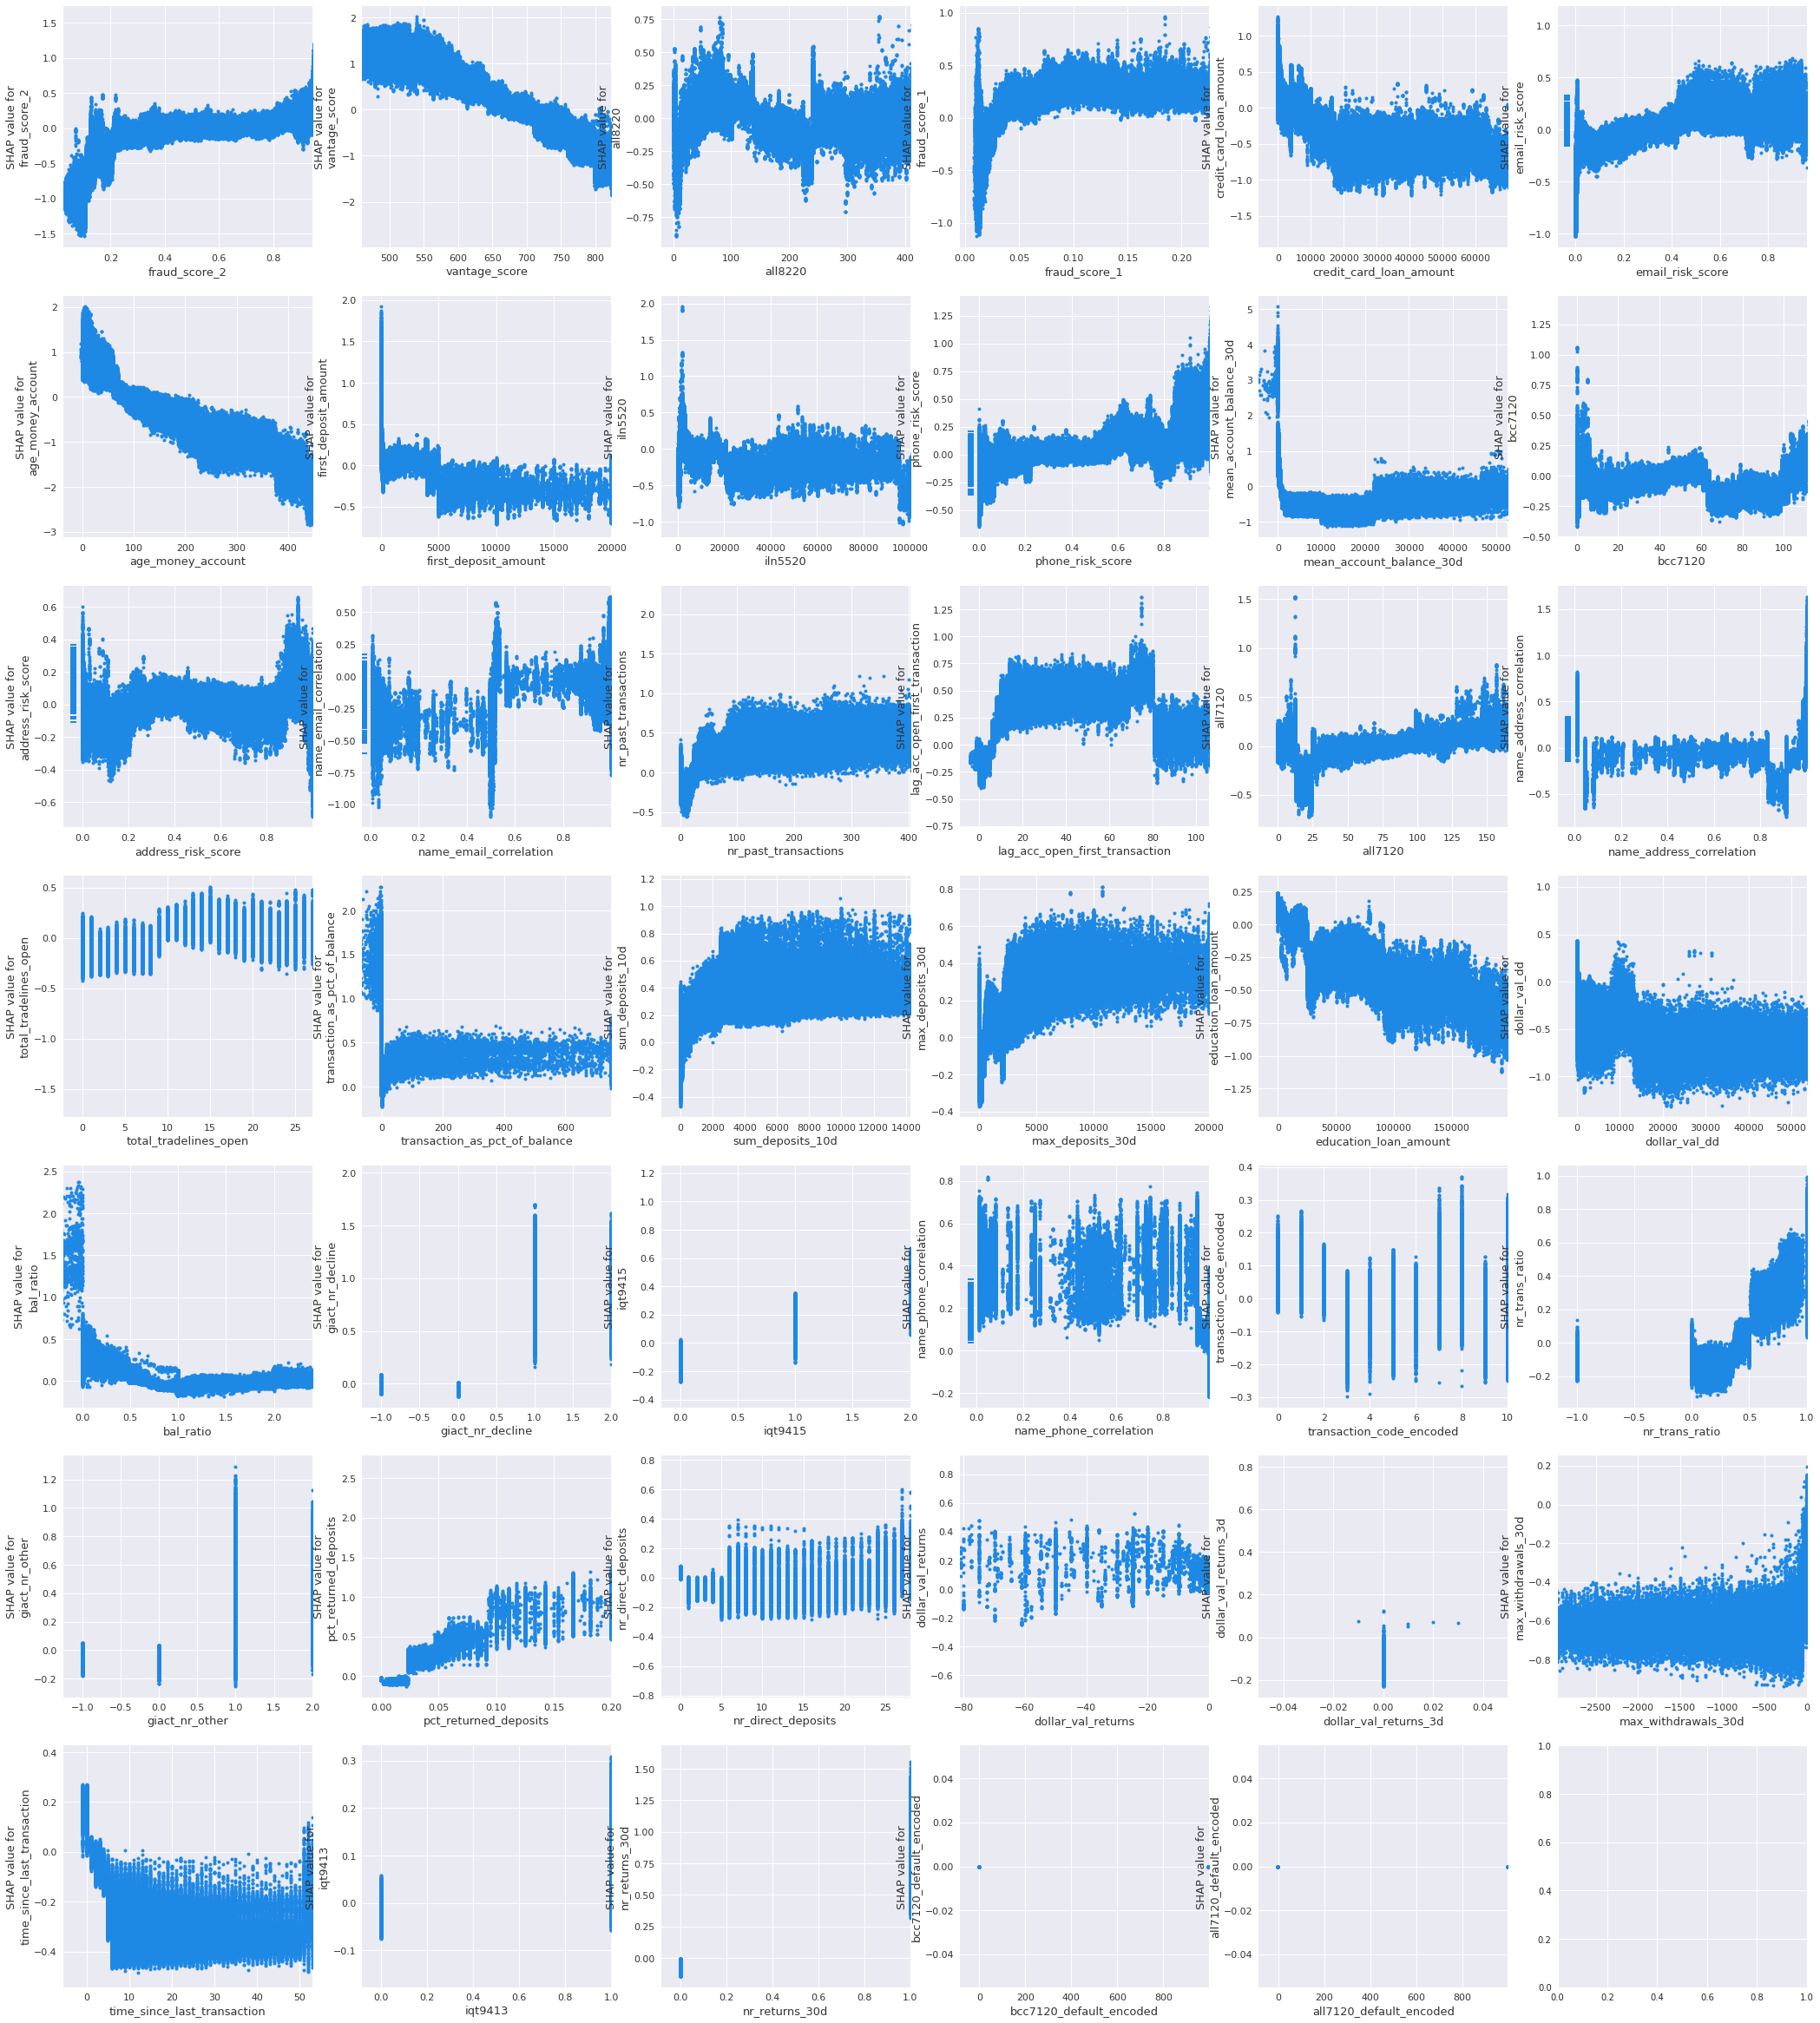

In [6]:
import math
import matplotlib.pyplot as plt
from tqdm import tqdm

def get_shap_dependence(df, shap_values, features, ncols=6, figsize=None, **kwargs):
    """
    Build the partial dependence plot for a set of models and features.
    """
    nrows = math.ceil(len(features) / ncols)

    if figsize is None:
        figsize = (ncols * 6, nrows * 6)

    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
    for feature, ax in zip(features, axs.flatten()):
        shap.dependence_plot(feature, shap_values, df, 
                             ax=ax, show=False, **kwargs)
        rlim = df[feature].quantile(0.98)
        llim = df[feature].quantile(0.02) - ((rlim - df[feature].quantile(0.02)) / 12)
            
        if rlim < np.inf and llim > -np.inf:
            ax.set_xlim(left=llim, right=rlim)
        
    return fig

# generate shap values
shap.initjs()
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(modeling_df[model.feature_name_])[1]

# if we use probability option: more interpretable, more time consuming
# explainer = shap.TreeExplainer(model, data=sample, model_output=model_output)  ## probability
# shap_values = explainer.shap_values(modeling_df[model.feature_name_])

# sort features by importance, prep for plotting
fimp = sorted(zip(model.feature_importances_, model.feature_name_), reverse=True)
features_by_imp = list(list(zip(*fimp))[1])

fig = get_shap_dependence(modeling_df[model.feature_name_], 
                          shap_values, features_by_imp, interaction_index=None)
# fig.savefig('../../artifacts/governance/shap_values_customer.png')

#### By Rows

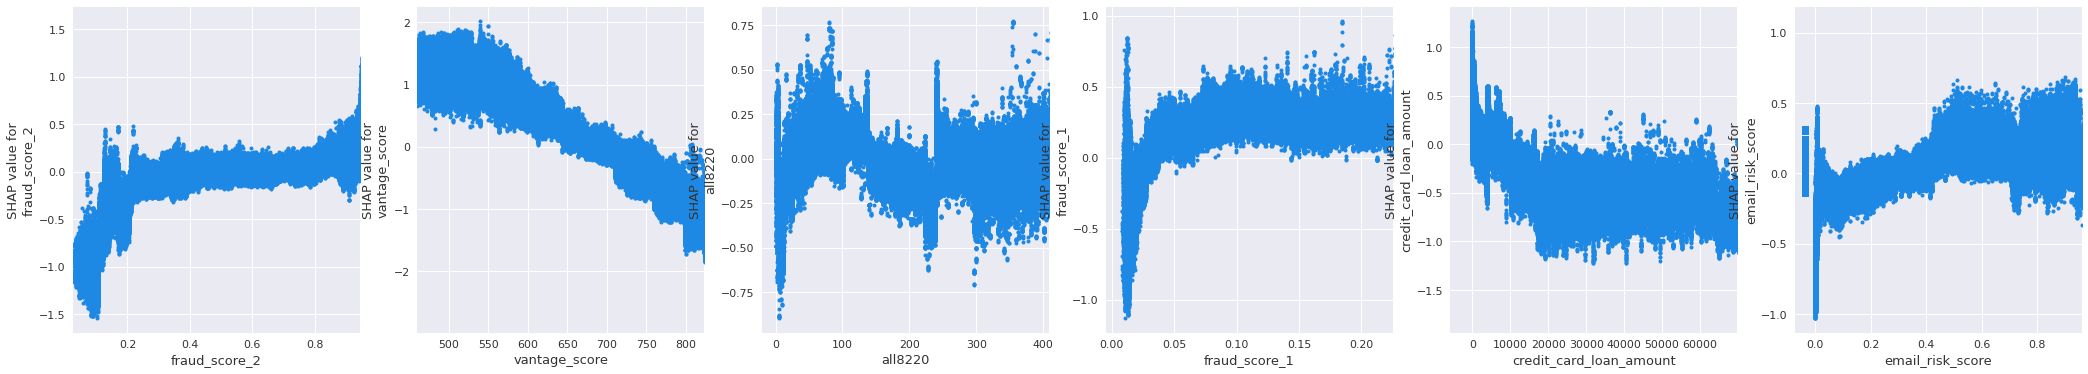

In [7]:
def get_idx(L, l):
    return [L.index(e) for e in l]

row = 0
features_sample = features_by_imp[row*6:row*6+6]
features_idx = get_idx(model.feature_name_, features_sample)
fig = get_shap_dependence(modeling_df[features_sample], 
                          shap_values[:, features_idx], 
                          features_sample, 
                          interaction_index=None)

#### By Features

(0.0, 100.0)

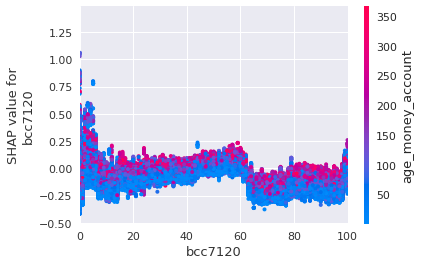

In [80]:
fig, ax = plt.subplots(1, 1)

shap.dependence_plot("bcc7120", shap_values, 
                     modeling_df[model.feature_name_], ax=ax, show=False)
ax.set_xlim(left=0, right=100)
# ax.set_ylim(1.00, -0.5)

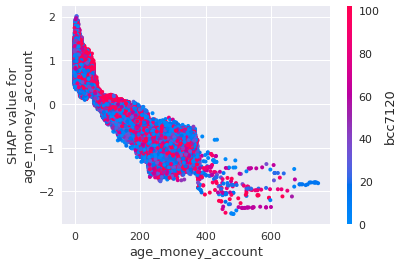

In [79]:
fig, ax = plt.subplots(1, 1)
shap.dependence_plot("age_money_account", shap_values, 
                     modeling_df[model.feature_name_], ax=ax, show=False)
# ax.set_xlim(left=0, right=100)
# ax.set_ylim(1.00, -0.5)

##### By Interaction Features

In [ ]:
def get_grid_plots(plot_fn, context, features, ncols=6, figsize=None, **kwargs):
    """
    build the grid plots with plot_fn and given context
    
    plot_fn(feature, context, ax), 
    plot_fn will use info in context to plot on ax, for provided feature
    """
    nrows = math.ceil(len(features) / ncols)
    
    if figsize is None:
        figsize = (ncols * 6, nrows * 6)
        
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
    for feature, ax in tqdm(zip(features, axs.flatten())):
        plot_fn(feature, context, ax, **kwargs)
    return fig

def plot_shap_dependence(feature, context, ax, **kwargs):
    shap_values = context["shap_values"]
    df = context["df"]
    shap.dependence_plot(feature, shap_values, df, 
                         ax=ax, show=False, **kwargs)
    rlim = df[feature].quantile(0.98)
    llim = df[feature].quantile(0.02) - ((rlim - df[feature].quantile(0.02)) / 12)

    if rlim < np.inf and llim > -np.inf:
        ax.set_xlim(left=llim, right=rlim)
    
    return ax

def plot_shap_interaction(feature, context, ax, interaction_index, **kwargs):
    """
    plot how given feature interact with the interaction_feature
    """
    shap_values = context["shap_values"]
    df = context["df"]
    shap.dependence_plot(interaction_index, shap_values, df, ax=ax, 
                         show=False, interaction_index=feature, **kwargs)
    rlim = df[interaction_index].quantile(0.98)
    llim = df[interaction_index].quantile(0.02) - ((rlim - df[interaction_index].quantile(0.02)) / 12)
    
    if rlim < np.inf and llim > -np.inf:
        ax.set_xlim(left=llim, right=rlim)
    
    return ax

In [ ]:
# %%time 

context = {"shap_values": shap_values,
           "df": modeling_df[model.feature_name_]}

for f in features_by_imp[:2]:
    print(f"Feature: {f}")
    fig = get_grid_plots(plot_shap_dependence,
                   context,
                   features_by_imp, 
                   interaction_index=f)
#     fig.savefig(f'../../artifacts/governance/shap_interactions/shap_values_{f}.png')
    plt.show()

#### Correlation
---

In [5]:
modeling_df.head()

,business_account_number,borrower_id,sample_date,target,transaction_code,first_deposit_amount,vantage_score,bcc7120,email_risk_score,fraud_score_2,...,iqt9413,dollar_val_returns_3d,nr_returns_30d,credit_card_loan_amount,fraud_score_1,age_money_account,transaction_code_encoded,all7120_default_encoded,bcc7120_default_encoded,pred
0,410000087395,5750052,2019-03-27 09:59:22,False,ACHDW,50.00,NaN,NaN,0.0272,NaN,...,NaN,0.0,0.0,NaN,0.0211,309,5,-1.0,-1.0,0.085010
1,410001352464,7313147,2019-09-20 05:50:31,False,ACHDDIN,2000.00,734.0,27.0,0.6170,0.312,...,0.0,0.0,0.0,6954.0,0.0293,176,4,-1.0,-1.0,0.017006
2,410000287298,2176154,2019-01-25 05:49:11,False,ACHINDD,100.00,NaN,NaN,0.0108,NaN,...,NaN,0.0,0.0,NaN,0.0293,71,6,-1.0,-1.0,0.055994
3,410000361702,851298,2019-11-25 10:32:35,False,DWCRDBILLPAY,2980.64,780.0,49.0,0.0077,NaN,...,0.0,0.0,0.0,6458.0,0.0356,331,0,-1.0,-1.0,0.025013
4,410000751441,7052381,2019-11-15 06:20:19,False,ACHINDD,300.00,737.0,75.0,0.4790,0.282,...,0.0,0.0,0.0,649.0,0.0191,273,6,-1.0,-1.0,0.002954


In [6]:
def get_corr_w_target(df, features, target_col="target"):
    corrs = []
    for f in features:
        c = df[[f, target_col]].astype(float).corr().iloc[1,0]
        corrs.append((f, c))
        
    corrs = pd.DataFrame(corrs)
    corrs.columns = ["feature", "corr"]
    return corrs

In [7]:
corr = get_corr_w_target(modeling_df, model.feature_name_, "target")

In [8]:
corr.head()

,feature,corr
0,first_deposit_amount,-0.009785
1,vantage_score,-0.306789
2,bcc7120,0.093625
3,email_risk_score,0.191485
4,fraud_score_2,0.201735


In [9]:
corr.set_index("feature", inplace=True)
corr.sort_values("corr", inplace=False)
corr.style.background_gradient(cmap ='coolwarm') 

,corr
feature,
first_deposit_amount,-0.009785
vantage_score,-0.306789
bcc7120,0.093625
email_risk_score,0.191485
fraud_score_2,0.201735
name_email_correlation,-0.055309
transaction_as_pct_of_balance,0.056354
mean_account_balance_30d,-0.039542
phone_risk_score,0.200733


#### WOE
---

In [5]:
from rdsutils.woe import WOE_Transform

In [6]:
%%time
woe = WOE_Transform(min_iv=-np.inf)
woe.fit(modeling_df[model.feature_name_], modeling_df["target"].astype(int), display=-1)

processed  41  num attributes

CPU times: user 1min 6s, sys: 569 ms, total: 1min 7s
Wall time: 1min 7s


In [7]:
pd.set_option('display.max_columns', None)
woe.display_bin_results(["vantage_score"], simple=0)

                  attr    min    max    #accts  %accts     #good     #bad  \
0        vantage_score  300.0  380.0     759.0   0.07%     400.0    359.0   
1        vantage_score  381.0  420.0    2295.0   0.21%    1621.0    674.0   
2        vantage_score  421.0  527.0   60243.0   5.55%   43454.0  16789.0   
3        vantage_score  528.0  537.0   10992.0   1.01%    8881.0   2111.0   
4        vantage_score  538.0  542.0    5723.0   0.53%    4632.0   1091.0   
5        vantage_score  543.0  548.0    7637.0   0.70%    6385.0   1252.0   
6        vantage_score  549.0  561.0   20728.0   1.91%   17534.0   3194.0   
7        vantage_score  562.0  583.0   35928.0   3.31%   32473.0   3455.0   
8        vantage_score  584.0  606.0   40436.0   3.72%   37336.0   3100.0   
9        vantage_score  607.0  662.0  115710.0  10.65%  111007.0   4703.0   
10       vantage_score  663.0  746.0  238269.0  21.94%  234775.0   3494.0   
11       vantage_score  747.0  839.0  362663.0  33.39%  360685.0   1978.0   

In [8]:
modeling_df[model.feature_name_].isna().sum()

first_deposit_amount                   0
vantage_score                     184800
bcc7120                           293534
email_risk_score                   26148
fraud_score_2                     246891
name_email_correlation             26148
transaction_as_pct_of_balance          0
mean_account_balance_30d               0
phone_risk_score                   26148
name_address_correlation           27111
all8220                           198019
lag_acc_open_first_transaction         0
dollar_val_dd                          0
all7120                           242424
sum_deposits_10d                       0
nr_past_transactions                   0
total_tradelines_open             163895
education_loan_amount             163895
address_risk_score                 27111
iqt9415                           178034
max_withdrawals_30d                    0
iln5520                           542546
max_deposits_30d                       0
pct_returned_deposits                  0
giact_nr_decline

In [9]:
df = woe.transform(modeling_df[model.feature_name_], keep=True) 

transformed num 20
transformed num 40



In [13]:
import math
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm


def plot_woe(fname, woe_dict, ax=None):
    if ax is None:
        fig = plt.figure()
    x = woe_dict[fname]["min"]
    y = woe_dict[fname]["woe"]
    ax.plot(x, y)
    ax.set_title(f"{fname}")
    
def get_woe_plots(df, woe_dict, features, ncols=6, figsize=None, **kwargs):
    """
    Build the partial dependence plot for a set of models and features.
    """
    nrows = math.ceil(len(features) / ncols)

    if figsize is None:
        figsize = (ncols * 6, nrows * 6)

    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
    for feature, ax in zip(features, axs.flatten()):
        plot_woe(feature, woe_dict, ax=ax)        
    return fig

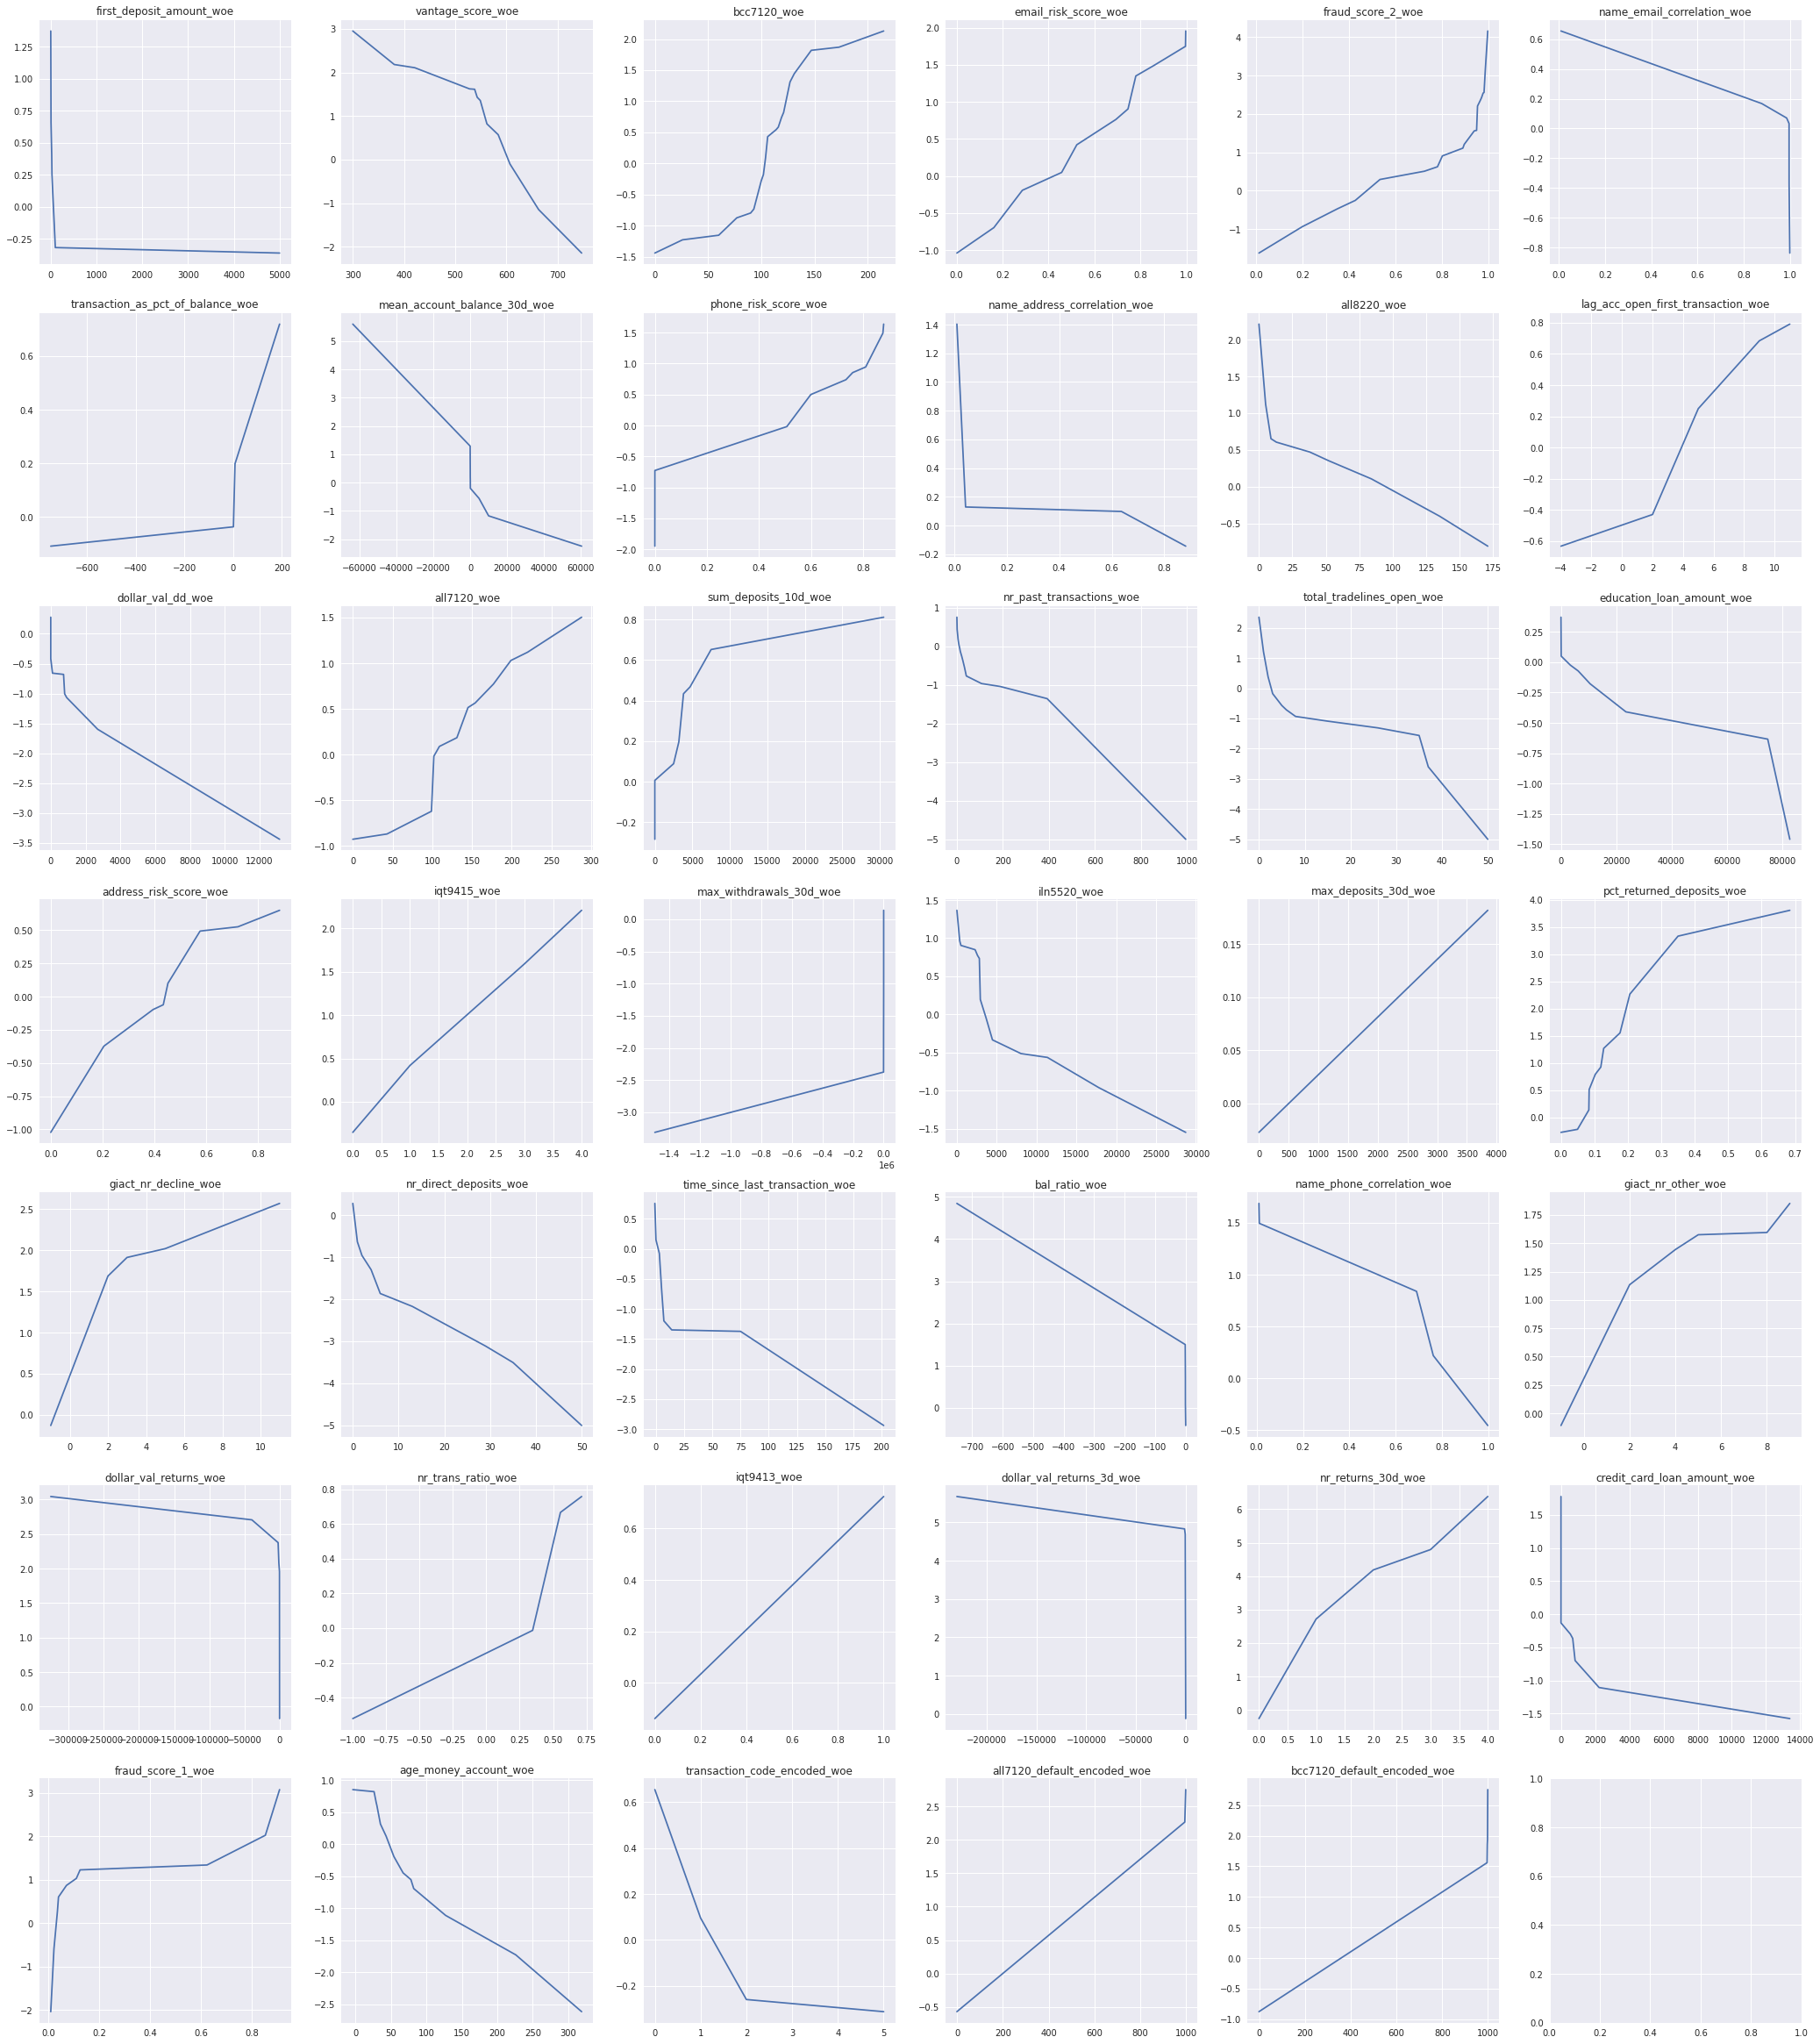

In [14]:
woe_dict = woe.woe_dict()
woe_dict = dict([(k+"_woe", v) for k,v in woe_dict.items()])
features_order = [k+"_woe" for k in model.feature_name_] # get the same order as lgbm + mc
fig = get_woe_plots(df, woe_dict, features_order)

#### TransactionVisualizer
---

#### ICE
---

#### PDP
---

In [72]:
import math
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


def partial_dependency(model, df, feature, features, 
                       n_steps=10, sample_size=None):
    """
    Calculate partial dependency of a feature given a model.
    """
    if sample_size:
        d = df.sample(sample_size).copy()
    else:
        d = df.copy()
    grid = np.linspace(df[feature].quantile(0.001),
                       df[feature].quantile(.995),
                       n_steps)
    preds = []

    for x in grid:
        d[feature] = x
        y = np.average(model.predict(d[features]))
        preds.append([x, y])
    return np.array(preds).T[0], np.array(preds).T[1]


def partial_dependency_plot_cv(ax, models, df, 
                               feature, features, n_steps=10, 
                               sample_size=None, ylab=None):
    """
    Return partial dependence plot for a feature on a set of models.
    """
    d = df.copy()

    partial_dependencies = []
    y_mean = np.array([0] * n_steps)
    x_mean = []

    y_min = np.inf
    y_max = -np.inf
    d[d[feature] == np.inf] = np.nan #edge case

    for model in models:
        x, y = partial_dependency(model, d, feature, 
                                  features, n_steps=n_steps, 
                                  sample_size=sample_size)
        
        y_min = min(y_min, min(y))
        y_max = max(y_max, max(y))
        
        y_mean = y_mean + (y / len(models))
        x_mean = x
        partial_dependencies.append([x, y])

        for x, y in partial_dependencies:
            ax.plot(x, y, '-', linewidth=1.4, alpha=0.6)

    ax.plot(x_mean, y_mean, '-', color = 'red', linewidth = 2.5)
    ax.set_xlim(d[feature].quantile(0.001), d[feature].quantile(0.995))
    ax.set_ylim(y_min*0.99, y_max*1.01)
    ax.set_xlabel(feature, fontsize = 10)
    if ylab:
        ax.set_ylabel(ylab, fontsize = 12)
                
            
def get_pdp(df, features, models, ncols=6, 
            figsize=None, sample_size=None):
    """
    Build the partial dependence plot for a set of models and features.
    """
    if type(models) is not list:
        models = [models]

    nrows = math.ceil(len(features) / ncols)

    if figsize is None:
        figsize = (ncols * 6, nrows * 6)

    fig, axs = plt.subplots(nrows=nrows, 
                            ncols=ncols, 
                            figsize=figsize)
    for feature, ax in tqdm(zip(features, axs.flatten())):
        try:
            partial_dependency_plot_cv(ax, models, df, 
                                       feature, features, 
                                       sample_size=sample_size)
        except:
            continue
    return fig

41it [1:12:14, 105.73s/it]


CPU times: user 17h 29min 53s, sys: 1min 51s, total: 17h 31min 44s
Wall time: 1h 12min 15s


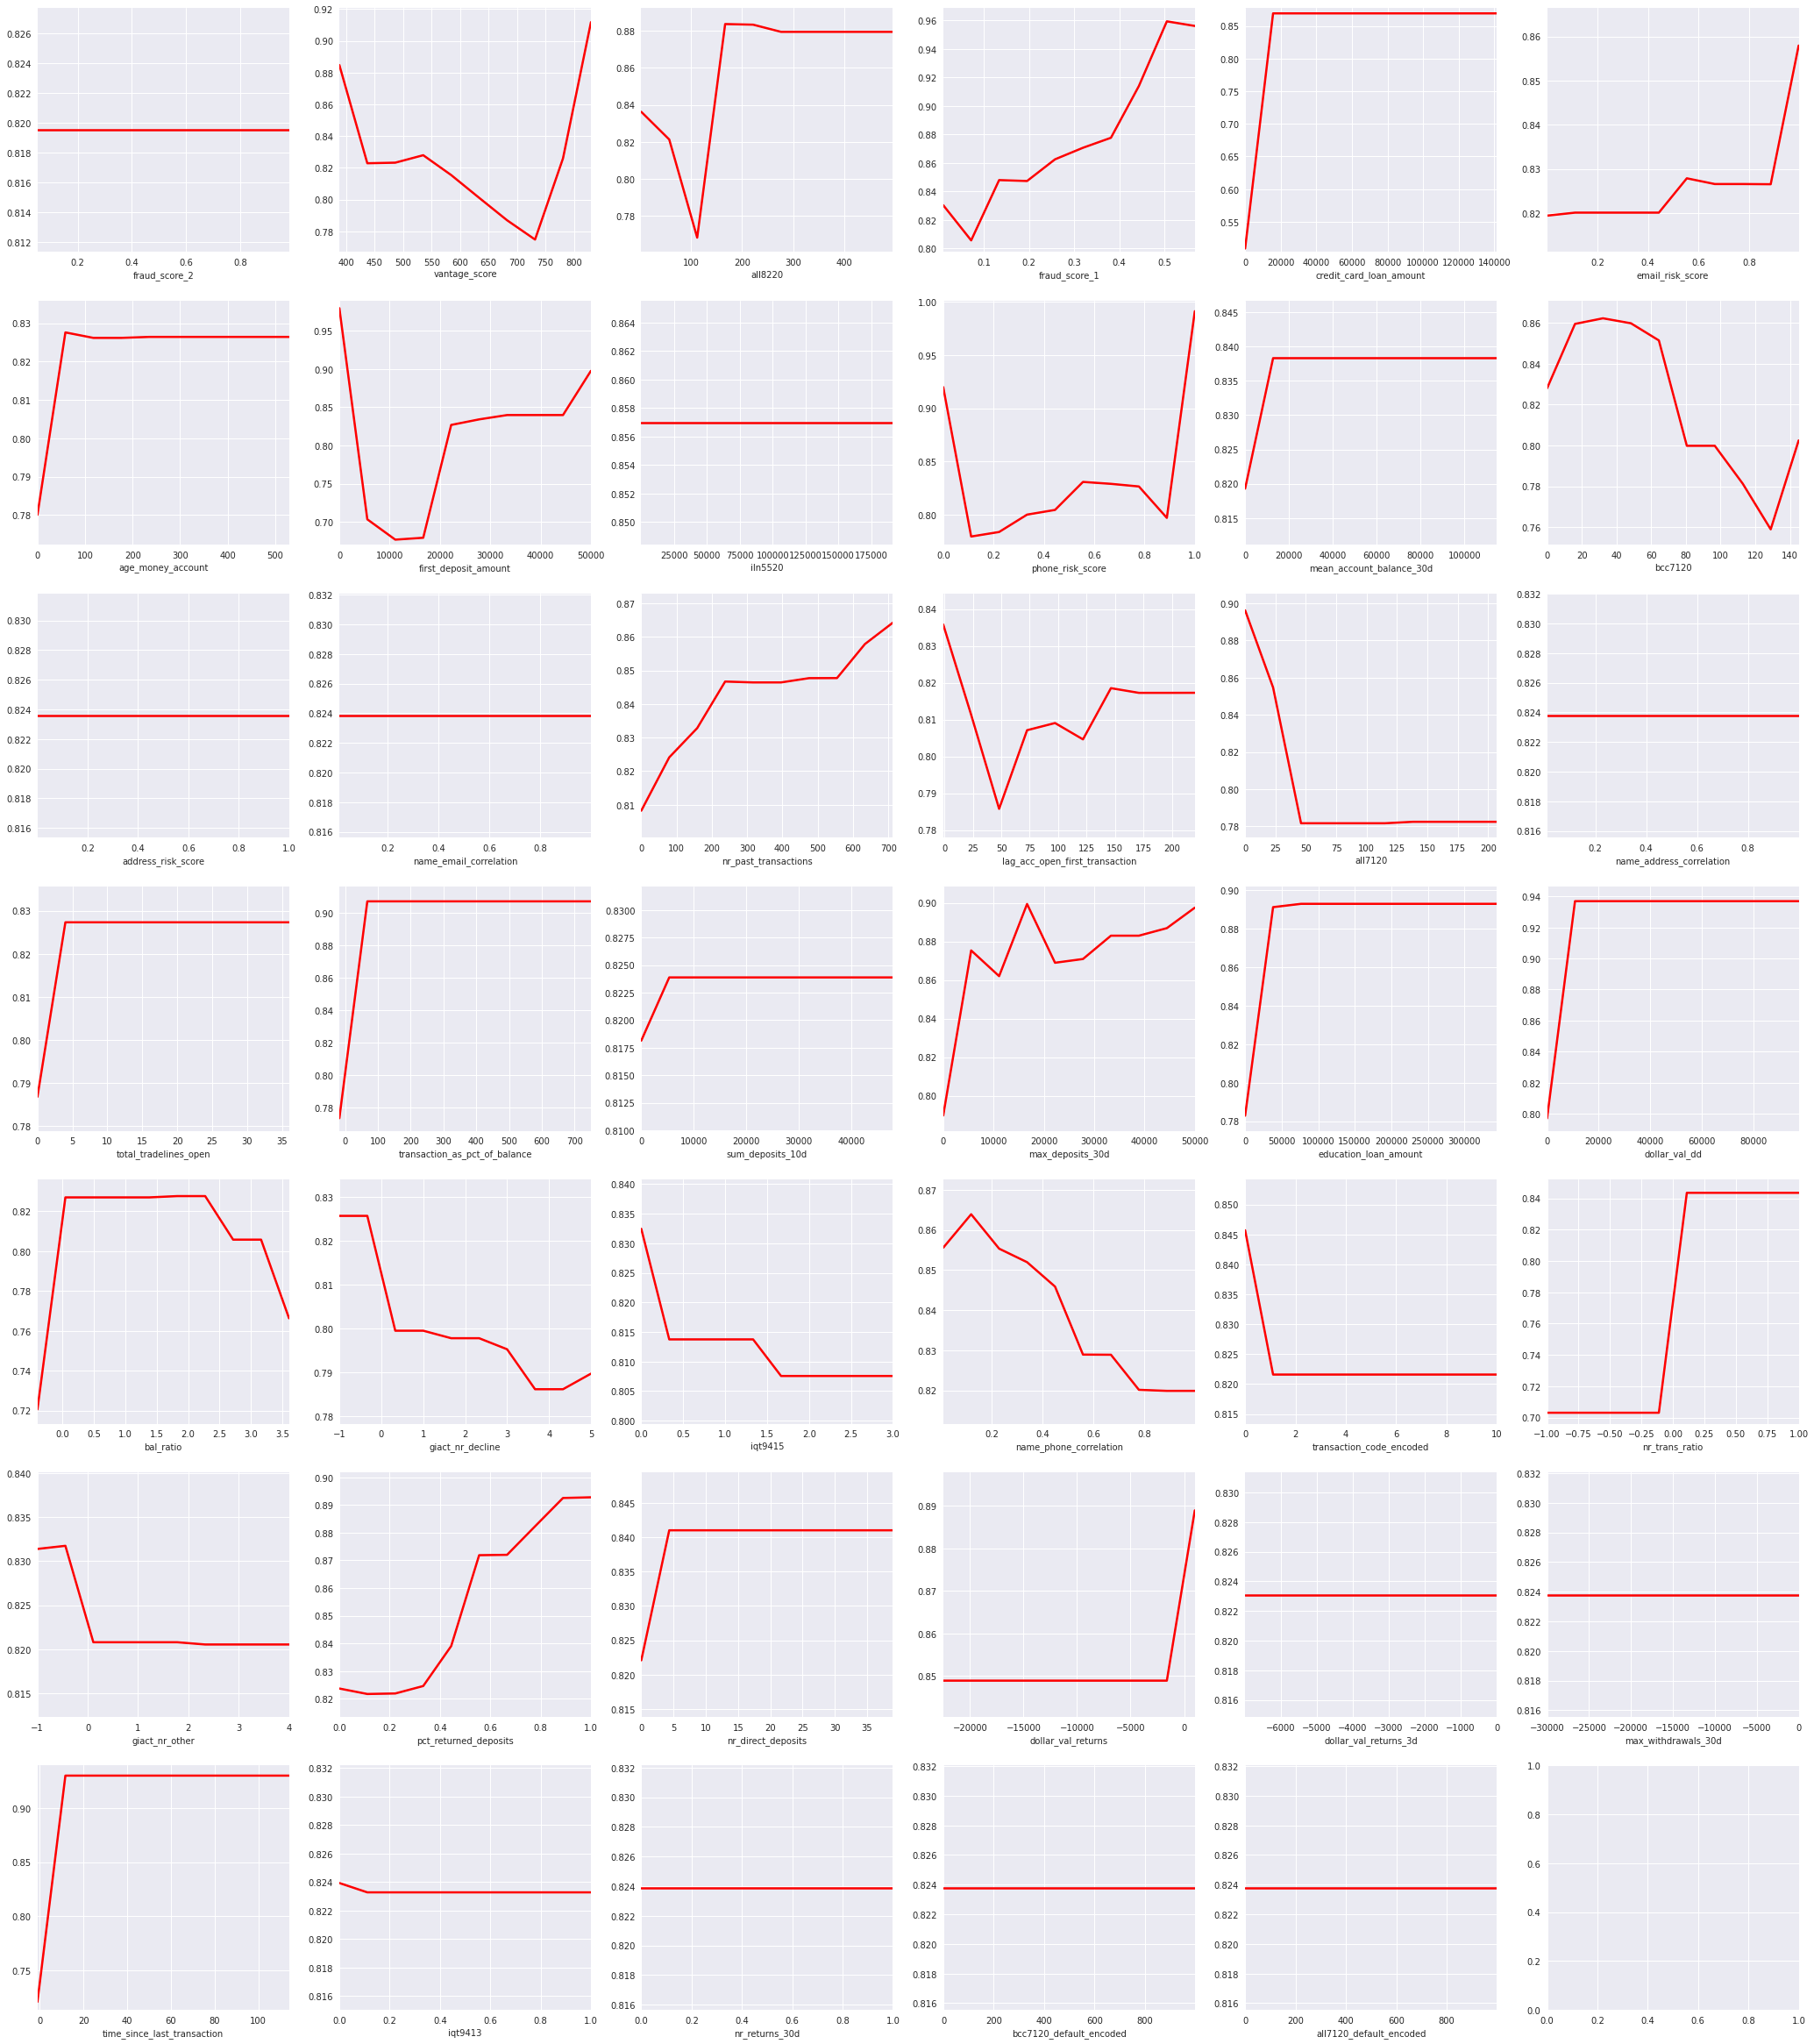

In [ ]:
%%time 
fig = get_pdp(modeling_df, features_by_imp, [model], ncols=6)

#### LIME
---

In [15]:
try:
    import lime
except:
    !pip install lime
    import lime

     |████████████████████████████████| 275 kB 8.3 MB/s eta 0:00:01
     |████████████████████████████████| 12.5 MB 8.7 MB/s eta 0:00:01     |██████████████████████████▋     | 10.4 MB 8.7 MB/s eta 0:00:01
     |████████████████████████████████| 3.3 MB 66.1 MB/s eta 0:00:01
     |████████████████████████████████| 157 kB 77.9 MB/s eta 0:00:01
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283846 sha256=25a69f3c481ccd2e5297d71a4add0d8fb73fc9021cf82fe82b4a7e35c704056f
  Stored in directory: /home/ec2-user/.cache/pip/wheels/ca/cb/e5/ac701e12d365a08917bf4c6171c0961bc880a8181359c66aa7
Successfully built lime


In [53]:
%%time
from lime.lime_tabular import LimeTabularExplainer

explainer = LimeTabularExplainer(modeling_df[model.feature_name_].values,
                                 mode='classification',
                                 training_labels='target',
                                 feature_names=model.feature_name_,
                                 categorical_features=[38, 39, 40],
                                 discretize_continuous=False)

CPU times: user 1.63 s, sys: 264 ms, total: 1.89 s
Wall time: 1.89 s


In [54]:
x = modeling_df[model.feature_name_].values[0]
pred_fn = lambda x: model.predict_proba(x).astype(float)
exp = explainer.explain_instance(x, pred_fn, num_features=20)
exp.show_in_notebook()

We won't be using LIME because it does not support NaN and infinity